# Plot results using the DataFrame stored in pickle file

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options

#Define plotting style:
sns.set() #Set style
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.2)

In [74]:
def getContour(xpts,ypts,zpts,levels):
    """
    Uses pyplot tricontour method to obtain contour
    curves in a 2D plane.

    :return: A dictionary with a list of contours for each level
    """
    
    import copy
    
    fig = plt.figure()
    x = copy.deepcopy(xpts)
    y = copy.deepcopy(ypts)
    z = copy.deepcopy(zpts)
    CS = plt.tricontour(x,y,z,levels=levels)    
    levelPts = {}
    for il,level in enumerate(CS.levels):
        levelPts[level] = []
        c = CS.collections[il]        
        paths = c.get_paths()
        for path in paths:
            levelPts[level].append(path.vertices)
    plt.close(fig)
    
    return levelPts


### Load results:

In [2]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('scan_results_atlas_2016_15.pcl')
#print(dataDF.columns.values.tolist()) #Print all columns names

In [5]:
#Set points without chi2 values to zero
chi2Cols = [col for col in dataDF.columns.values if '.chi2' in col]
for col in chi2Cols:
    dataDF.fillna(value={col : 0.0},inplace=True)

#### Now sum up the chi2 values for each combination of SRs and store its value in the chi2Max column

In [35]:
resCols = [col for col in dataDF.columns.values if 'ExptRes.result' in col and 'AnalysisID' in col]
#Set max chi2 to zero:
dataDF['chi2Max'] = 0.
dataDF['chi2MaxComb'] = 0.
dataDF['SRMaxComb'] = 'None'
chisq95Limit = {'SRA' : 7.815, 'SRB' : 7.815, 'SRC' : 11.070}

for i in dataDF.index:
    chi2Combined = {'SRA' : 0., 'SRB' : 0., 'SRC' : 0.}
    chi2Single = []
    r = dataDF.loc[i]
    for col in resCols:
        dsID = r[col.replace('AnalysisID','DataSetID')]
        chi2 = r[col.replace('AnalysisID','chi2')]
        chi2Single.append(chi2)
        if not dsID or pd.isna(dsID):
            continue
        for sr in chi2Combined:
            if sr in dsID:
                chi2Combined[sr] += chi2
    chi2Max = max(chi2Single)
    chi2MaxComb = None
    SRMaxComb = 'None'
    for k,chi2 in chi2Combined.items():
        if chi2MaxComb is None or chi2-chisq95Limit[k] > chi2MaxComb:
            chi2MaxComb = chi2-chisq95Limit[k]
            SRMaxComb = k
    
    dataDF.loc[i,'chi2Max'] = chi2Max-3.84
    dataDF.loc[i,'chi2MaxComb'] = chi2MaxComb
    dataDF.loc[i,'SRMaxComb'] = SRMaxComb

In [81]:
contours = getContour(dataDF['mass.1000006'],dataDF['mass.1000022'],dataDF['chi2Max'],[0.0])

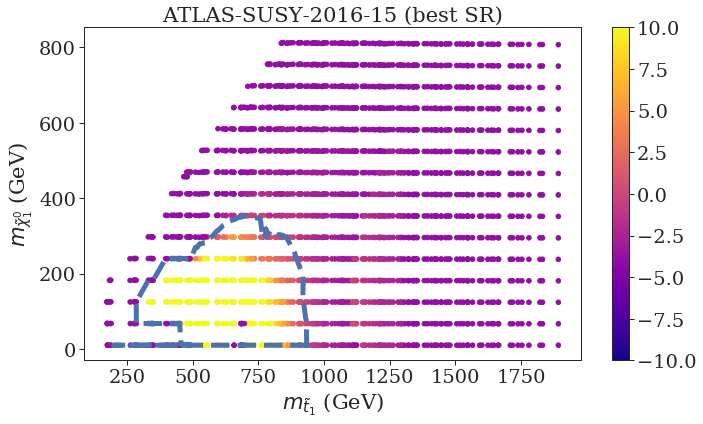

In [83]:
plt.figure(figsize=(10,6))
ax = plt.scatter(dataDF['mass.1000006'],dataDF['mass.1000022'],c=dataDF['chi2Max'],
                 cmap='plasma',vmin=-10,vmax=10)
cont = list(contours.values())[0][0]
plt.plot(cont[:,0],cont[:,1],'--',linewidth=5)
plt.colorbar(ax)
# plt.xlim(0,1000)
# plt.ylim(0,1200)
plt.xlabel(r'$m_{\tilde{t}_1}$ (GeV)')
plt.ylabel(r'$m_{\tilde{\chi}_1^0}$ (GeV)')
plt.title('ATLAS-SUSY-2016-15 (best SR)')
plt.tight_layout()
plt.show()

In [84]:
contours2 = getContour(dataDF['mass.1000006'],dataDF['mass.1000022'],dataDF['chi2MaxComb'],[0.0])

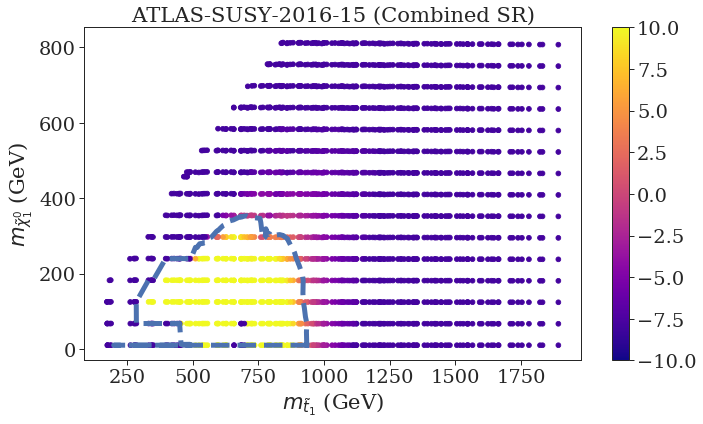

In [88]:
plt.figure(figsize=(10,6))
ax = plt.scatter(dataDF['mass.1000006'],dataDF['mass.1000022'],c=dataDF['chi2MaxComb'],
                 cmap='plasma',vmin=-10,vmax=10)
contB = list(contours.values())[0][0]
plt.plot(contB[:,0],contB[:,1],'--',linewidth=5)
# plt.plot(cont[:,0],cont[:,1],'--',linewidth=1)
plt.colorbar(ax)
# plt.xlim(0,1000)
# plt.ylim(0,1200)
plt.xlabel(r'$m_{\tilde{t}_1}$ (GeV)')
plt.ylabel(r'$m_{\tilde{\chi}_1^0}$ (GeV)')
plt.title('ATLAS-SUSY-2016-15 (Combined SR)')
plt.tight_layout()
plt.show()